<a href="https://colab.research.google.com/github/mamuncseru/EpilepsyDetectionRNNExperimentTensorFlow/blob/main/EpilepsyDetectionRNNExperimentTensorFlow_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM, GRU
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


In [2]:
## seed 
np.random.seed(2023)

## Reading CSV data

In [3]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.shape

(11500, 180)

In [4]:
raw_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [5]:
raw_data.values.shape

(11500, 180)

In [6]:
data = raw_data.values # converted to an numpy array
data = data[:, 1:] # discarding the Unnamed Column
data.shape

(11500, 179)

In [7]:
# let's see how it looks like
data

array([[135, 190, 229, ..., -83, -51, 4],
       [386, 382, 356, ..., 143, 129, 1],
       [-32, -39, -47, ..., -35, -36, 5],
       ...,
       [14, 6, -13, ..., -1, -8, 5],
       [-40, -25, -9, ..., 59, 55, 3],
       [29, 41, 57, ..., 2, 20, 4]], dtype=object)

In [8]:
# let's see the type 
type(data)

numpy.ndarray

## Classifying data categories as it mentioned in the paper

In [9]:
df_1 = data[data[:, -1] == 1].astype(int) # seizure
df_2 = data[data[:, -1] == 2].astype(int)
df_3 = data[data[:, -1] == 3].astype(int)
df_4 = data[data[:, -1] == 4].astype(int)
df_5 = data[data[:, -1] == 5].astype(int)

# let's print the shape of each category
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Let's plot some random data points from every category

In [10]:
def visualize_eeg(number_of_datapoints):
    for i in (np.random.randint(0, 2300, number_of_datapoints)):
        plt.plot(df_1[i, :], 'r-', label='df_1')
        plt.plot(df_2[i, :], 'g-', label='df_2')
        plt.plot(df_3[i, :], 'k-', label='df_3')
        plt.plot(df_4[i, :], 'b-', label='df_4')
        plt.plot(df_5[i, :], 'm-', label='df_5')
        plt.legend()
        plt.title(f'visualizing {i} th data point')
        plt.xlabel('time')
        plt.ylabel('aplitude(uV)')
        plt.show()

### Visualizing all categories in single figure

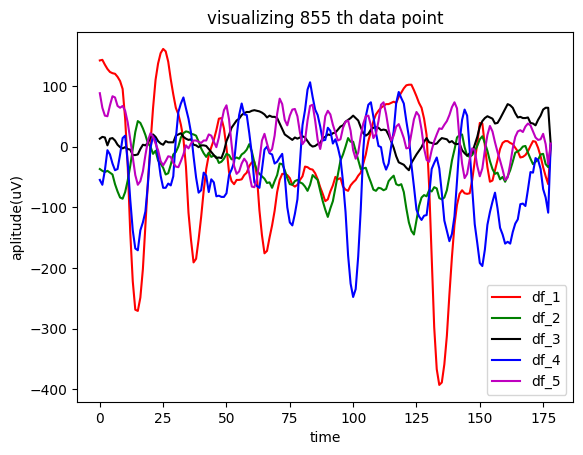

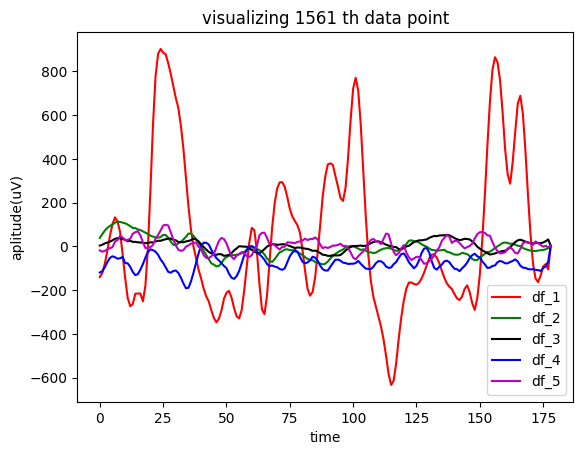

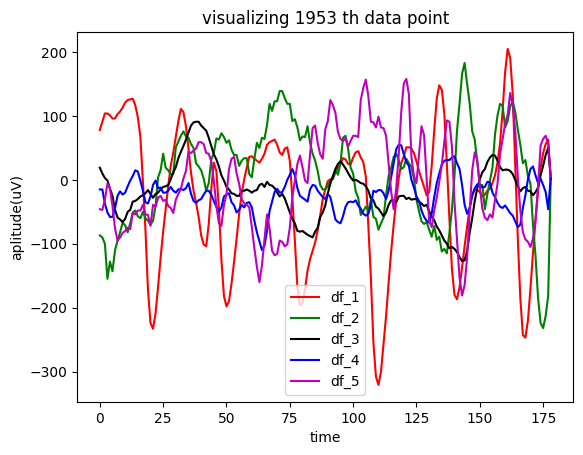

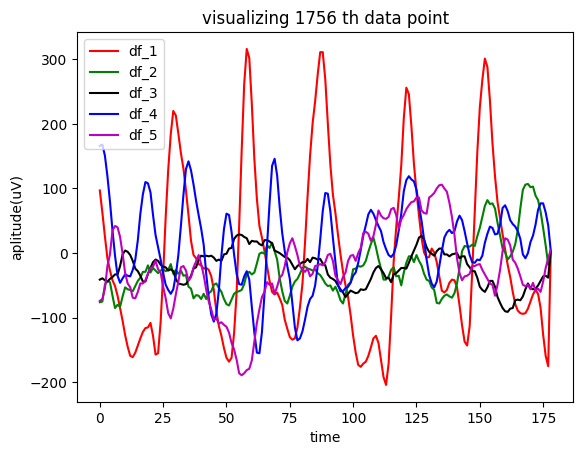

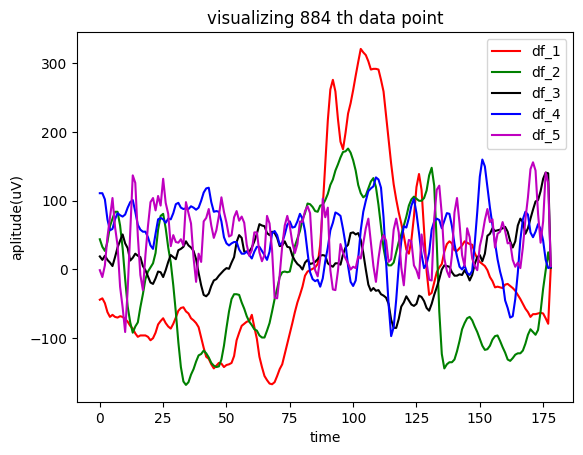

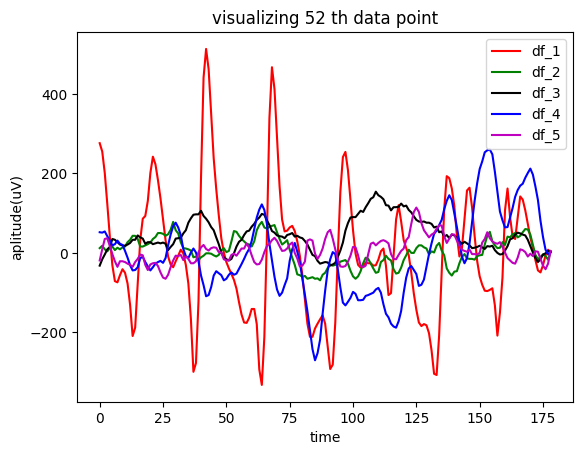

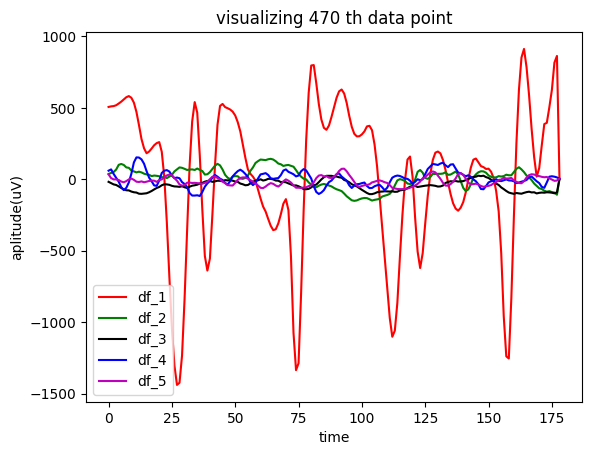

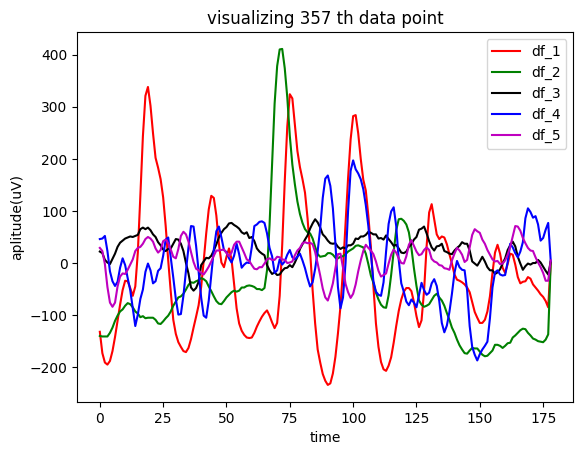

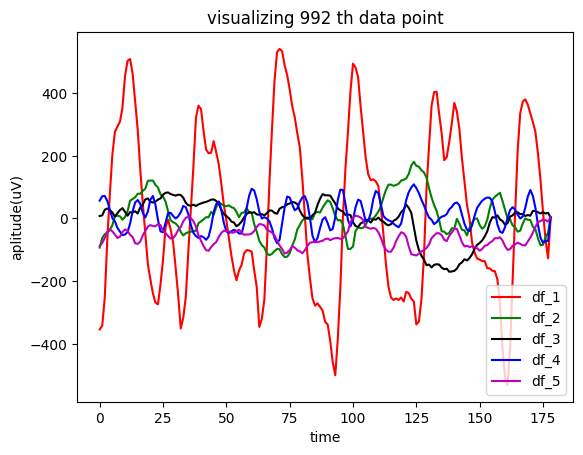

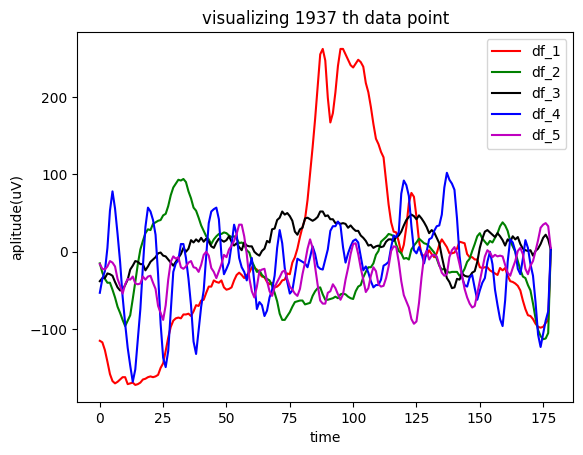

In [ ]:
### all categories
visualize_eeg(10)

## Converting data into integer and making the data into seizure and non-seizure cateogry

In [11]:
all_data = data.copy().astype('int')

In [12]:
all_data

array([[135, 190, 229, ..., -83, -51,   4],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   5],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   5],
       [-40, -25,  -9, ...,  59,  55,   3],
       [ 29,  41,  57, ...,   2,  20,   4]])

In [13]:
all_data[:, -1] = np.where(all_data[:, -1] != 1, 0, all_data[:, -1])
all_data

array([[135, 190, 229, ..., -83, -51,   0],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   0],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   0],
       [-40, -25,  -9, ...,  59,  55,   0],
       [ 29,  41,  57, ...,   2,  20,   0]])

In [14]:
print(len(all_data[all_data[:, -1] == 1]))
print(len(all_data[all_data[:, -1] == 0]))

2300
9200


## Merge and Split dataset for training, validation and testing (80%:10%:10%)

In [15]:
def split_data(data, random_state=2023):
    
    X = all_data[:, :-1]
    y = all_data[:, -1]

    X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, stratify=y, test_size=.2, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, stratify=y_valtest, test_size=.5, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test



In [16]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(all_data)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(9200, 178)
(1150, 178)
(1150, 178)
(9200,)
(1150,)
(1150,)


### let's expand the dimension to fit the data

In [17]:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(9200, 178, 1)
(1150, 178, 1)
(1150, 178, 1)


In [18]:
input_shape = (X_train.shape[1], 1)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

## Defining the LSTM network architecture

## Model 1



In [ ]:
# class eegClassifier(keras.Model):
#     def __init__(self, input_shape):
#         super(eegClassifier, self).__init__()

#         self.dense_1 = Dense(units=32, activation='relu')
#         self.lstm = LSTM(units=128)
#         self.dropout_1 = Dropout(0.3)
#         self.bn_1 = BatchNormalization()

#         self.dense_2 = Dense(units=64, activation='relu')
#         self.dropout_2 = Dropout(0.3)
#         self.bn_2 = BatchNormalization()
#         self.output_layer = Dense(units=2, activation='softmax')


#     def call(self, inputs):
#         x = self.dense_1(inputs)
#         x = self.bn_1(self.dropout_1(self.lstm(x)))
#         x = self.bn_2(self.dropout_2(self.dense_2(x)))
#         x = self.output_layer(x)

#         return x

# model = eegClassifier(input_shape)
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

In [ ]:
class eegClassifier(keras.Model):
    def __init__(self, input_shape):
        super(eegClassifier, self).__init__()

        self.lstm = LSTM(units=128)

        self.bn = BatchNormalization()
        self.dropout = Dropout(0.3)
        
        self.dense_1 = Dense(units=32, activation='relu')
        self.dense_2 = Dense(units=64, activation='relu')
        self.output_layer = Dense(units=2, activation='softmax')


    def call(self, inputs):
        x = self.dropout(self.lstm(inputs))
        x = self.bn(self.dropout(self.dense_1(x)))
        x = self.dropout(self.dense_2(x))
        x = self.output_layer(x)

        return x


model = eegClassifier(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

Epoch 1/50
288/288 [==============================] - 13s 11ms/step - loss: 0.2814 - accuracy: 0.8936 - val_loss: 0.1552 - val_accuracy: 0.9478
Epoch 2/50
288/288 [==============================] - 3s 12ms/step - loss: 0.1579 - accuracy: 0.9489 - val_loss: 0.1124 - val_accuracy: 0.9652
Epoch 3/50
288/288 [==============================] - 3s 10ms/step - loss: 0.1366 - accuracy: 0.9547 - val_loss: 0.1086 - val_accuracy: 0.9678
Epoch 4/50
288/288 [==============================] - 3s 9ms/step - loss: 0.1521 - accuracy: 0.9449 - val_loss: 0.0959 - val_accuracy: 0.9687
Epoch 5/50
288/288 [==============================] - 3s 9ms/step - loss: 0.1134 - accuracy: 0.9589 - val_loss: 0.1220 - val_accuracy: 0.9496
Epoch 6/50
288/288 [==============================] - 3s 12ms/step - loss: 0.1023 - accuracy: 0.9643 - val_loss: 0.0844 - val_accuracy: 0.9678
Epoch 7/50
288/288 [==============================] - 3s 9ms/step - loss: 0.0906 - accuracy: 0.9690 - val_loss: 0.1306 - val_accuracy: 0.9600
E

In [ ]:
class eegClassifier(keras.Model):
    def __init__(self, input_shape, lstm_units=128):
        super(eegClassifier, self).__init__()

        self.lstm = LSTM(units=lstm_units)

        self.bn = BatchNormalization()
        self.dropout = Dropout(0.3)

        self.dense_1 = Dense(units=32, activation='relu')
        self.dense_2 = Dense(units=64, activation='relu')
        self.output_layer = Dense(units=2, activation='softmax')


    def call(self, inputs):
        x = self.dropout(self.lstm(inputs))
        x = self.bn(self.dropout(self.dense_1(x)))
        x = self.dropout(self.dense_2(x))
        x = self.output_layer(x)

        return x



In [ ]:
model = eegClassifier(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### function to plot accuracy curve of the training and validation accuracy


In [19]:
def plot_loss(history):
    plt.plot(history.history['loss'], 'b-')
    plt.plot(history.history['val_loss'], 'r-')
    plt.legend(['loss', 'val_loss'])
    plt.title('Loss curve')
    plt.xlabel('Epochs') 
    plt.ylabel('Loss %')
    plt.show()

### function to plot accuracy curve of the training and validation accuracy


In [20]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], 'b-')
    plt.plot(history.history['val_accuracy'], 'r-')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.title('Accuracy curve')
    plt.xlabel('Epochs') 
    plt.ylabel('accuracy %')
    plt.show()

## Let's experiment with LSTM units

`lstm_units = [8, 16, 32, 64, 128, 256, 512, 1024]`





---- lstm unit = 8-------
Epoch 1/100
288/288 [==============================] - 7s 11ms/step - loss: 0.4688 - accuracy: 0.7992 - val_loss: 0.3817 - val_accuracy: 0.8513
Epoch 2/100
288/288 [==============================] - 3s 11ms/step - loss: 0.3839 - accuracy: 0.8508 - val_loss: 0.2972 - val_accuracy: 0.8887
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.3741 - accuracy: 0.8447 - val_loss: 0.3411 - val_accuracy: 0.8435
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.3508 - accuracy: 0.8550 - val_loss: 0.2835 - val_accuracy: 0.8904
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.2888 - accuracy: 0.8917 - val_loss: 0.2076 - val_accuracy: 0.9296
Epoch 6/100
288/288 [==============================] - 3s 11ms/step - loss: 0.2421 - accuracy: 0.9127 - val_loss: 0.1819 - val_accuracy: 0.9383
Epoch 7/100
288/288 [==============================] - 3s 9ms/step - loss: 0.2362 - accuracy: 0.9203 - val_lo

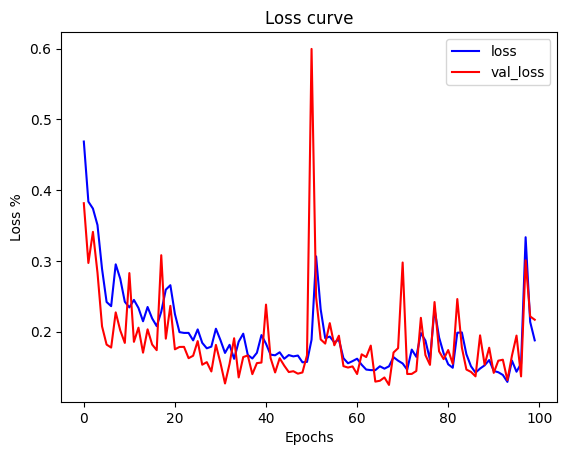

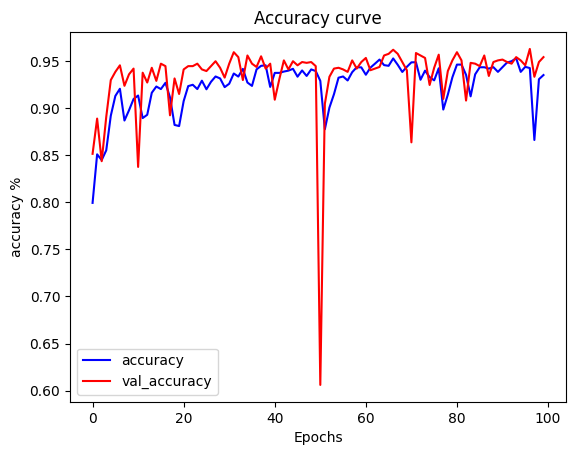





---- lstm unit = 16-------
Epoch 1/100
288/288 [==============================] - 7s 12ms/step - loss: 0.4306 - accuracy: 0.8138 - val_loss: 0.2626 - val_accuracy: 0.9096
Epoch 2/100
288/288 [==============================] - 3s 9ms/step - loss: 0.2846 - accuracy: 0.8947 - val_loss: 0.1698 - val_accuracy: 0.9383
Epoch 3/100
288/288 [==============================] - 3s 11ms/step - loss: 0.2209 - accuracy: 0.9240 - val_loss: 0.1962 - val_accuracy: 0.9357
Epoch 4/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1947 - accuracy: 0.9315 - val_loss: 0.1542 - val_accuracy: 0.9522
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1778 - accuracy: 0.9403 - val_loss: 0.1233 - val_accuracy: 0.9626
Epoch 6/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1721 - accuracy: 0.9413 - val_loss: 0.1171 - val_accuracy: 0.9652
Epoch 7/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1664 - accuracy: 0.9427 - val_l

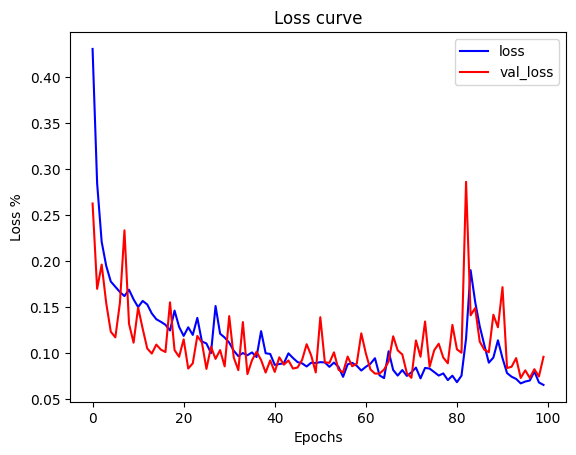

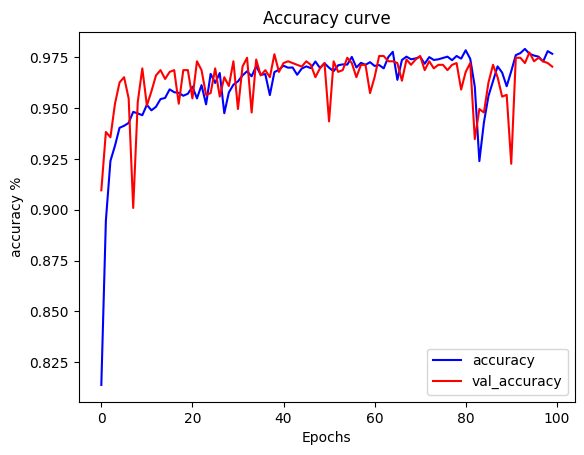





---- lstm unit = 32-------
Epoch 1/100
288/288 [==============================] - 7s 12ms/step - loss: 0.3780 - accuracy: 0.8405 - val_loss: 0.2340 - val_accuracy: 0.9130
Epoch 2/100
288/288 [==============================] - 3s 12ms/step - loss: 0.2302 - accuracy: 0.9211 - val_loss: 0.1660 - val_accuracy: 0.9365
Epoch 3/100
288/288 [==============================] - 3s 10ms/step - loss: 0.2051 - accuracy: 0.9290 - val_loss: 0.1603 - val_accuracy: 0.9348
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1990 - accuracy: 0.9317 - val_loss: 0.1653 - val_accuracy: 0.9426
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1873 - accuracy: 0.9360 - val_loss: 0.1641 - val_accuracy: 0.9287
Epoch 6/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1541 - accuracy: 0.9493 - val_loss: 0.1063 - val_accuracy: 0.9652
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1478 - accuracy: 0.9511 - val

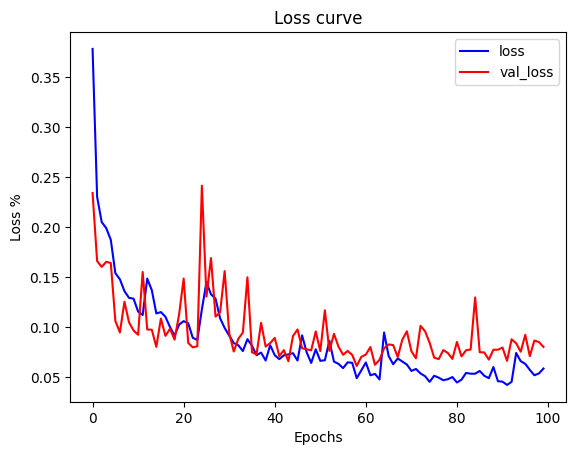

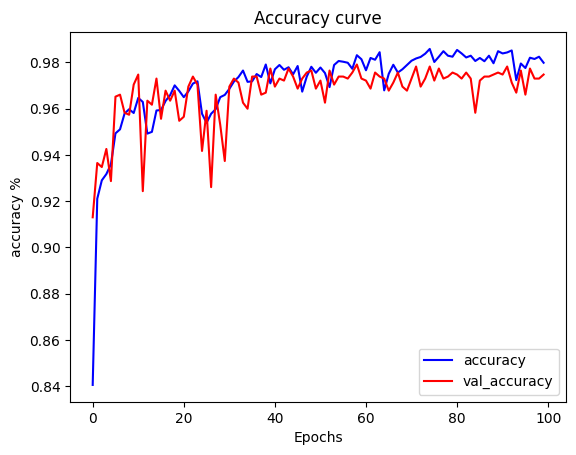





---- lstm unit = 64-------
Epoch 1/100
288/288 [==============================] - 7s 15ms/step - loss: 0.3143 - accuracy: 0.8725 - val_loss: 0.1480 - val_accuracy: 0.9470
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1930 - accuracy: 0.9387 - val_loss: 0.1425 - val_accuracy: 0.9478
Epoch 3/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1473 - accuracy: 0.9514 - val_loss: 0.1028 - val_accuracy: 0.9617
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1357 - accuracy: 0.9545 - val_loss: 0.2591 - val_accuracy: 0.9070
Epoch 5/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1389 - accuracy: 0.9553 - val_loss: 0.1021 - val_accuracy: 0.9635
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1220 - accuracy: 0.9624 - val_loss: 0.0980 - val_accuracy: 0.9643
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1183 - accuracy: 0.9603 - v

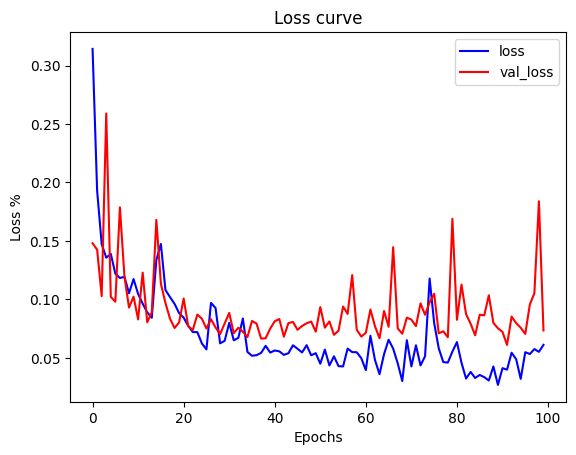

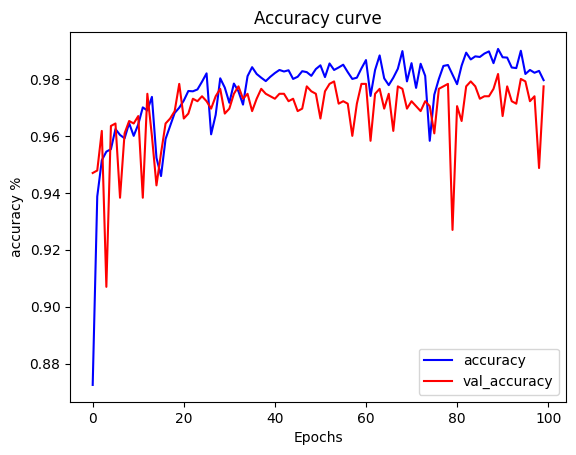





---- lstm unit = 128-------
Epoch 1/100
288/288 [==============================] - 8s 13ms/step - loss: 0.3124 - accuracy: 0.8725 - val_loss: 0.3019 - val_accuracy: 0.9035
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.2024 - accuracy: 0.9323 - val_loss: 0.1245 - val_accuracy: 0.9478
Epoch 3/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1478 - accuracy: 0.9505 - val_loss: 0.1214 - val_accuracy: 0.9565
Epoch 4/100
288/288 [==============================] - 4s 12ms/step - loss: 0.1310 - accuracy: 0.9521 - val_loss: 0.1153 - val_accuracy: 0.9583
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1421 - accuracy: 0.9483 - val_loss: 0.1100 - val_accuracy: 0.9565
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1237 - accuracy: 0.9551 - val_loss: 0.1071 - val_accuracy: 0.9626
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1245 - accuracy: 0.9560 - 

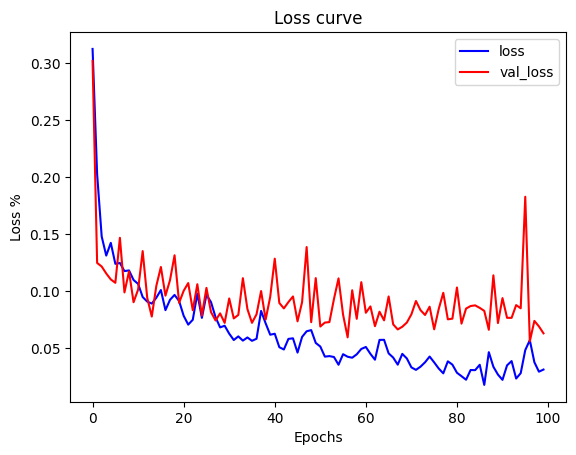

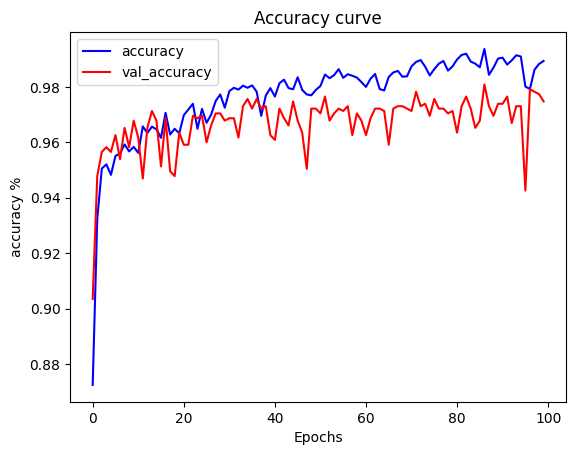





---- lstm unit = 256-------
Epoch 1/100
288/288 [==============================] - 7s 15ms/step - loss: 0.2431 - accuracy: 0.9110 - val_loss: 0.1264 - val_accuracy: 0.9496
Epoch 2/100
288/288 [==============================] - 4s 14ms/step - loss: 0.1389 - accuracy: 0.9530 - val_loss: 0.1221 - val_accuracy: 0.9583
Epoch 3/100
288/288 [==============================] - 4s 12ms/step - loss: 0.1166 - accuracy: 0.9579 - val_loss: 0.1218 - val_accuracy: 0.9591
Epoch 4/100
288/288 [==============================] - 4s 13ms/step - loss: 0.1180 - accuracy: 0.9592 - val_loss: 0.1014 - val_accuracy: 0.9643
Epoch 5/100
288/288 [==============================] - 4s 13ms/step - loss: 0.1292 - accuracy: 0.9516 - val_loss: 0.1079 - val_accuracy: 0.9600
Epoch 6/100
288/288 [==============================] - 4s 13ms/step - loss: 0.1087 - accuracy: 0.9622 - val_loss: 0.0900 - val_accuracy: 0.9626
Epoch 7/100
288/288 [==============================] - 4s 13ms/step - loss: 0.0944 - accuracy: 0.9658 - 

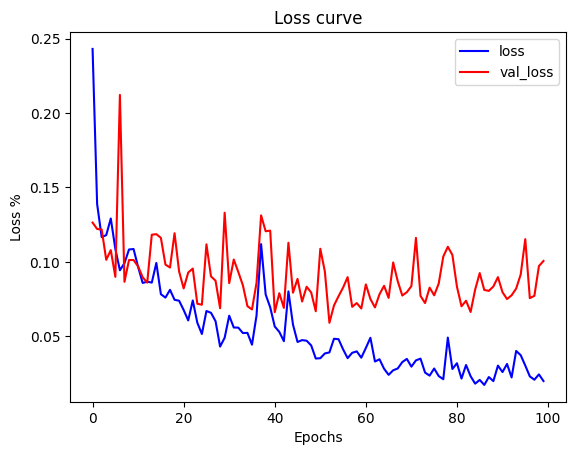

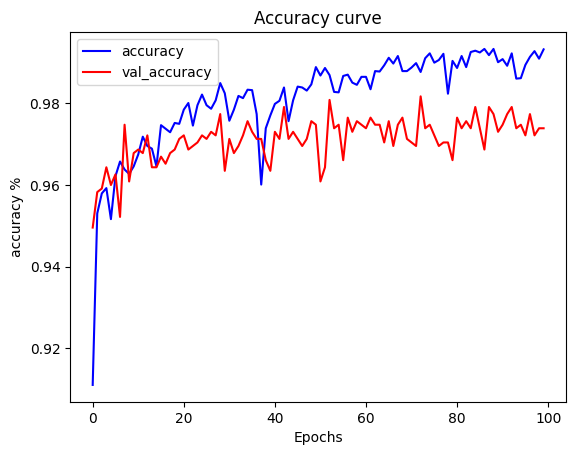





---- lstm unit = 512-------
Epoch 1/100
288/288 [==============================] - 12s 28ms/step - loss: 0.2232 - accuracy: 0.9193 - val_loss: 0.1084 - val_accuracy: 0.9530
Epoch 2/100
288/288 [==============================] - 7s 25ms/step - loss: 0.1318 - accuracy: 0.9542 - val_loss: 0.1078 - val_accuracy: 0.9635
Epoch 3/100
288/288 [==============================] - 7s 25ms/step - loss: 0.1231 - accuracy: 0.9585 - val_loss: 0.1074 - val_accuracy: 0.9635
Epoch 4/100
288/288 [==============================] - 8s 26ms/step - loss: 0.1220 - accuracy: 0.9566 - val_loss: 0.0907 - val_accuracy: 0.9626
Epoch 5/100
288/288 [==============================] - 7s 26ms/step - loss: 0.1019 - accuracy: 0.9648 - val_loss: 0.1096 - val_accuracy: 0.9574
Epoch 6/100
288/288 [==============================] - 7s 25ms/step - loss: 0.1007 - accuracy: 0.9665 - val_loss: 0.1254 - val_accuracy: 0.9704
Epoch 7/100
288/288 [==============================] - 8s 26ms/step - loss: 0.0902 - accuracy: 0.9685 -

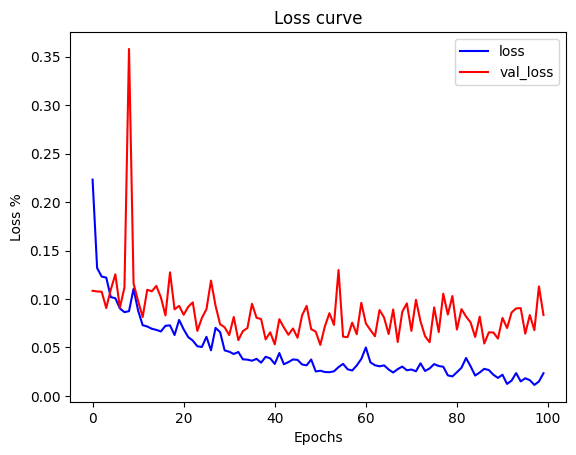

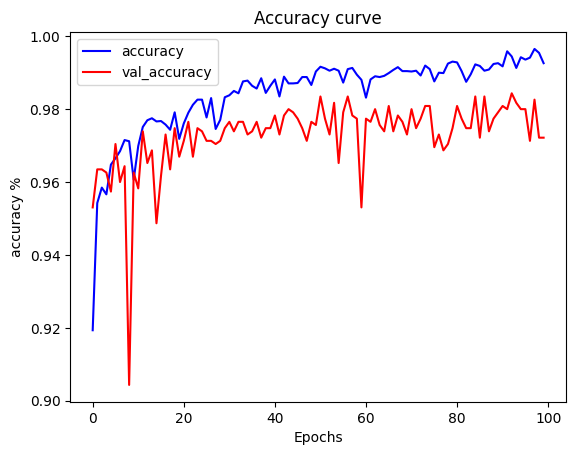





---- lstm unit = 1024-------
Epoch 1/100
288/288 [==============================] - 25s 71ms/step - loss: 0.1926 - accuracy: 0.9323 - val_loss: 0.1194 - val_accuracy: 0.9565
Epoch 2/100
288/288 [==============================] - 20s 69ms/step - loss: 0.1266 - accuracy: 0.9566 - val_loss: 0.1057 - val_accuracy: 0.9678
Epoch 3/100
288/288 [==============================] - 19s 67ms/step - loss: 0.1153 - accuracy: 0.9562 - val_loss: 0.1228 - val_accuracy: 0.9557
Epoch 4/100
288/288 [==============================] - 20s 68ms/step - loss: 0.1107 - accuracy: 0.9614 - val_loss: 0.1096 - val_accuracy: 0.9626
Epoch 5/100
288/288 [==============================] - 19s 67ms/step - loss: 0.1508 - accuracy: 0.9470 - val_loss: 0.1177 - val_accuracy: 0.9557
Epoch 6/100
288/288 [==============================] - 20s 68ms/step - loss: 0.1318 - accuracy: 0.9521 - val_loss: 0.1161 - val_accuracy: 0.9574
Epoch 7/100
288/288 [==============================] - 20s 68ms/step - loss: 0.1160 - accuracy: 0

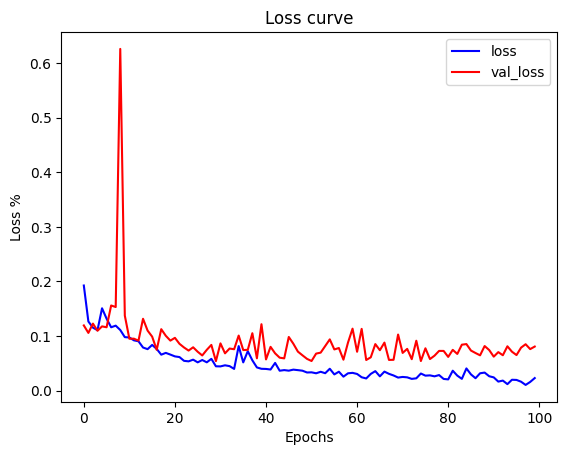

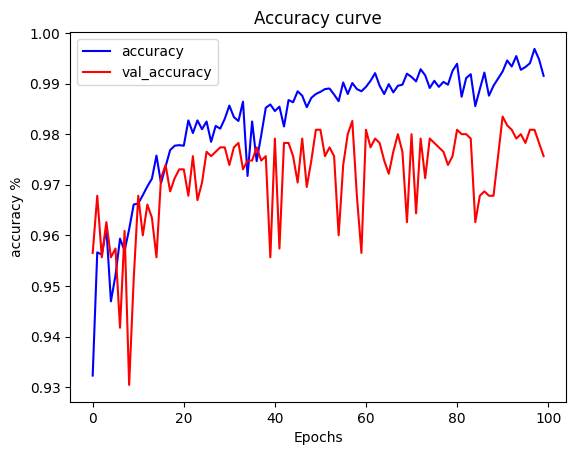

In [ ]:
lstm_all_units = [8, 16, 32, 64, 128, 256, 512, 1024]

all_lstmunits_history = []
all_lstmunits_models = []

for lstm_units in lstm_all_units:
    model = eegClassifier(input_shape, lstm_units)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print('\n\n\n')
    print(f'---- lstm unit = {lstm_units}-------')
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
    all_lstmunits_models.append(model)
    print('\n\n')
    print(model.summary())
    print('\n')
    plot_loss(history)
    plot_accuracy(history) 

    all_lstmunits_history.append(history)

In [21]:
class eegClassifier(keras.Model):
    def __init__(self, input_shape, lstm_layers_num):
        super(eegClassifier, self).__init__()

        self.lstm_layers = []
        for i in range(lstm_layers_num):
            lstm_layer = LSTM(units=128 * 2**i, return_sequences=True if i < lstm_layers_num-1 else False)
            setattr(self, f'lstm_{i}', lstm_layer)
            self.lstm_layers.append(lstm_layer)

        self.bn = BatchNormalization()
        self.dropout = Dropout(0.3)

        self.dense_1 = Dense(units=32, activation='relu')
        self.dense_2 = Dense(units=64, activation='relu')
        self.output_layer = Dense(units=2, activation='softmax')


    def call(self, inputs):
        x = inputs
        for lstm_layer in self.lstm_layers:
            x = self.dropout(lstm_layer(x))
        x = self.bn(self.dropout(self.dense_1(x)))
        x = self.dropout(self.dense_2(x))
        x = self.output_layer(x)

        return x


## Let's experiment with LSTM layers

`lstm_all_layers= [1, 2, 3, 4, 5, 6]`





---- lstm layer num = 1-------
Epoch 1/100
288/288 [==============================] - 12s 13ms/step - loss: 0.3137 - accuracy: 0.8767 - val_loss: 0.1728 - val_accuracy: 0.9409
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1777 - accuracy: 0.9432 - val_loss: 0.1146 - val_accuracy: 0.9522
Epoch 3/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1455 - accuracy: 0.9534 - val_loss: 0.1645 - val_accuracy: 0.9443
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1285 - accuracy: 0.9592 - val_loss: 0.0929 - val_accuracy: 0.9678
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1238 - accuracy: 0.9576 - val_loss: 0.1052 - val_accuracy: 0.9643
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1077 - accuracy: 0.9628 - val_loss: 0.0996 - val_accuracy: 0.9643
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0956 - accuracy: 0.9686

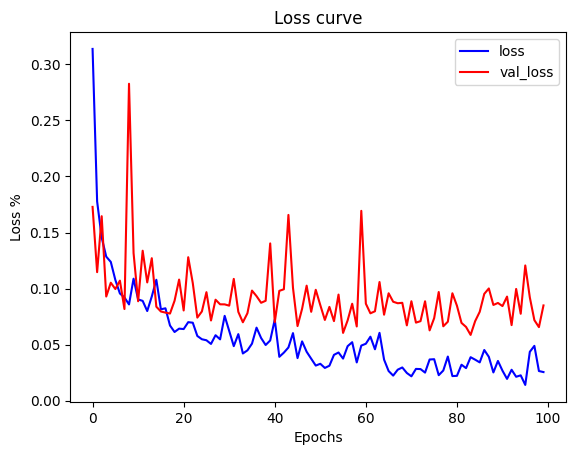

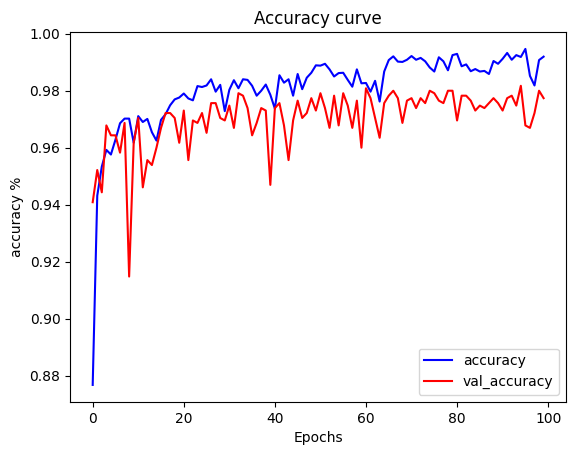





---- lstm layer num = 2-------
Epoch 1/100
288/288 [==============================] - 12s 26ms/step - loss: 0.2384 - accuracy: 0.9171 - val_loss: 0.5410 - val_accuracy: 0.8017
Epoch 2/100
288/288 [==============================] - 5s 19ms/step - loss: 0.1796 - accuracy: 0.9385 - val_loss: 0.1146 - val_accuracy: 0.9574
Epoch 3/100
288/288 [==============================] - 6s 20ms/step - loss: 0.1334 - accuracy: 0.9547 - val_loss: 0.1318 - val_accuracy: 0.9522
Epoch 4/100
288/288 [==============================] - 6s 19ms/step - loss: 0.1243 - accuracy: 0.9543 - val_loss: 0.1292 - val_accuracy: 0.9496
Epoch 5/100
288/288 [==============================] - 6s 19ms/step - loss: 0.1090 - accuracy: 0.9620 - val_loss: 0.1746 - val_accuracy: 0.9435
Epoch 6/100
288/288 [==============================] - 6s 20ms/step - loss: 0.1094 - accuracy: 0.9571 - val_loss: 0.1522 - val_accuracy: 0.9574
Epoch 7/100
288/288 [==============================] - 5s 18ms/step - loss: 0.0980 - accuracy: 0.964

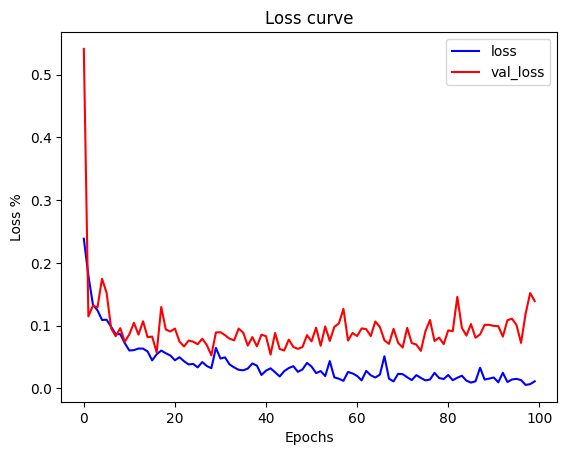

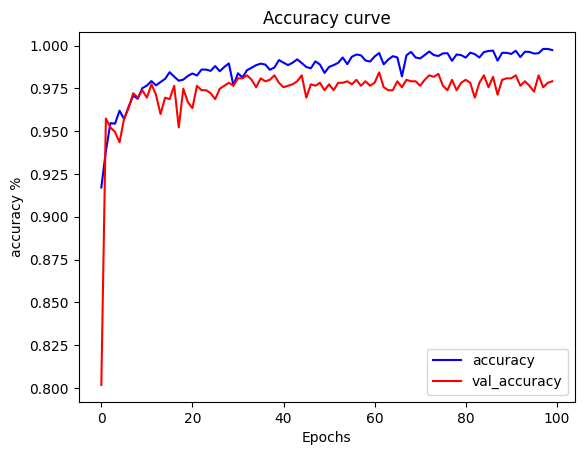





---- lstm layer num = 3-------
Epoch 1/100
288/288 [==============================] - 22s 52ms/step - loss: 0.2714 - accuracy: 0.8996 - val_loss: 0.1896 - val_accuracy: 0.9557
Epoch 2/100
288/288 [==============================] - 13s 46ms/step - loss: 0.1550 - accuracy: 0.9478 - val_loss: 0.1132 - val_accuracy: 0.9626
Epoch 3/100
288/288 [==============================] - 14s 47ms/step - loss: 0.1200 - accuracy: 0.9591 - val_loss: 0.1086 - val_accuracy: 0.9635
Epoch 4/100
288/288 [==============================] - 13s 45ms/step - loss: 0.1167 - accuracy: 0.9617 - val_loss: 0.0864 - val_accuracy: 0.9670
Epoch 5/100
288/288 [==============================] - 13s 45ms/step - loss: 0.0903 - accuracy: 0.9710 - val_loss: 0.1218 - val_accuracy: 0.9383
Epoch 6/100
288/288 [==============================] - 13s 45ms/step - loss: 0.1123 - accuracy: 0.9633 - val_loss: 0.0883 - val_accuracy: 0.9696
Epoch 7/100
288/288 [==============================] - 13s 45ms/step - loss: 0.0828 - accuracy:

In [ ]:
lstm_all_layers= [1, 2, 3, 4, 5, 6]

all_lstmlayers_history = []
all_lstmlayers_models = []

for lstm_layers_num in lstm_all_layers:
    model = eegClassifier(input_shape, lstm_layers_num)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print('\n\n\n')
    print(f'---- lstm layer num = {lstm_layers_num}-------')
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
    all_lstmunits_models.append(model)
    print('\n\n')
    print(model.summary())
    print('\n')
    plot_loss(history)
    plot_accuracy(history) 

    all_lstmunits_history.append(history)

In [ ]:
class eegClassifier(keras.Model):
    def __init__(self, input_shape, gru_units=128):
        super(eegClassifier, self).__init__()

        self.gru = GRU(units=gru_units)

        self.bn = BatchNormalization()
        self.dropout = Dropout(0.3)

        self.dense_1 = Dense(units=32, activation='relu')
        self.dense_2 = Dense(units=64, activation='relu')
        self.output_layer = Dense(units=2, activation='softmax')


    def call(self, inputs):
        x = self.dropout(self.gru(inputs))
        x = self.bn(self.dropout(self.dense_1(x)))
        x = self.dropout(self.dense_2(x))
        x = self.output_layer(x)

        return x



In [ ]:
model = eegClassifier(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Let's experiment with GRU units

`gru_units = [8, 16, 32, 64, 128, 256, 512, 1024]`





---- GRU unit = 8-------
Epoch 1/100
288/288 [==============================] - 7s 13ms/step - loss: 0.4635 - accuracy: 0.7872 - val_loss: 0.3027 - val_accuracy: 0.8817
Epoch 2/100
288/288 [==============================] - 3s 9ms/step - loss: 0.3385 - accuracy: 0.8632 - val_loss: 0.2150 - val_accuracy: 0.9243
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.2457 - accuracy: 0.9135 - val_loss: 0.1657 - val_accuracy: 0.9426
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.2152 - accuracy: 0.9272 - val_loss: 0.1620 - val_accuracy: 0.9461
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.2091 - accuracy: 0.9335 - val_loss: 0.1603 - val_accuracy: 0.9522
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.2148 - accuracy: 0.9217 - val_loss: 0.1829 - val_accuracy: 0.9470
Epoch 7/100
288/288 [==============================] - 3s 9ms/step - loss: 0.2043 - accuracy: 0.9288 - val_los

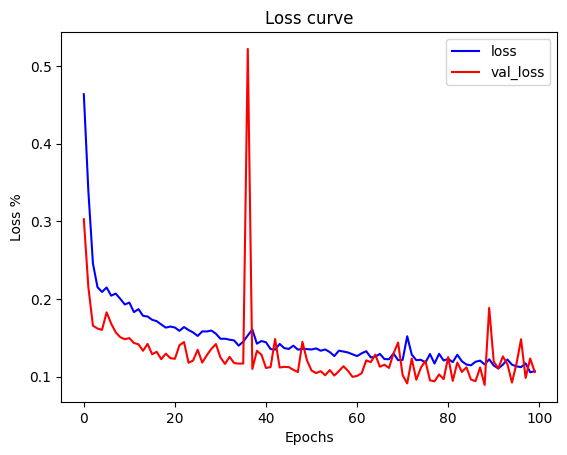

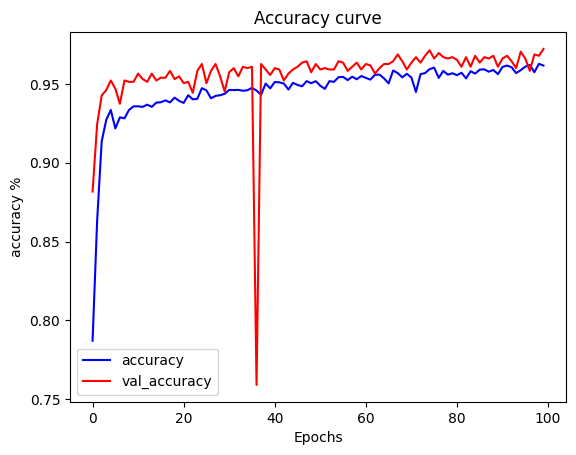





---- GRU unit = 16-------
Epoch 1/100
288/288 [==============================] - 6s 11ms/step - loss: 0.4620 - accuracy: 0.7918 - val_loss: 0.2649 - val_accuracy: 0.8965
Epoch 2/100
288/288 [==============================] - 3s 11ms/step - loss: 0.2821 - accuracy: 0.8972 - val_loss: 0.2094 - val_accuracy: 0.9235
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.2172 - accuracy: 0.9243 - val_loss: 0.1659 - val_accuracy: 0.9452
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.2158 - accuracy: 0.9290 - val_loss: 0.1536 - val_accuracy: 0.9478
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1969 - accuracy: 0.9360 - val_loss: 0.1425 - val_accuracy: 0.9461
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1862 - accuracy: 0.9350 - val_loss: 0.1626 - val_accuracy: 0.9487
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1800 - accuracy: 0.9363 - val_l

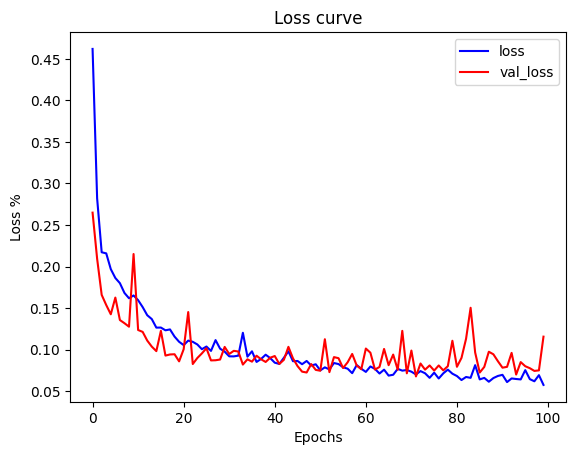

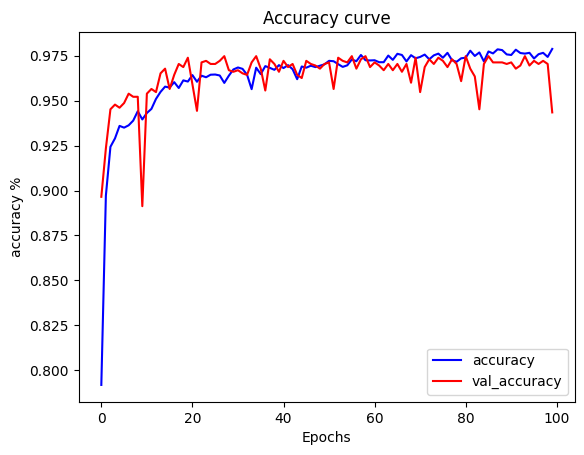





---- GRU unit = 32-------
Epoch 1/100
288/288 [==============================] - 7s 11ms/step - loss: 0.3701 - accuracy: 0.8440 - val_loss: 0.2015 - val_accuracy: 0.9252
Epoch 2/100
288/288 [==============================] - 3s 9ms/step - loss: 0.2161 - accuracy: 0.9266 - val_loss: 0.1589 - val_accuracy: 0.9504
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1901 - accuracy: 0.9389 - val_loss: 0.1307 - val_accuracy: 0.9478
Epoch 4/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1408 - accuracy: 0.9516 - val_loss: 0.1306 - val_accuracy: 0.9565
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1268 - accuracy: 0.9570 - val_loss: 0.0920 - val_accuracy: 0.9617
Epoch 6/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1144 - accuracy: 0.9583 - val_loss: 0.0893 - val_accuracy: 0.9678
Epoch 7/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1086 - accuracy: 0.9589 - val_los

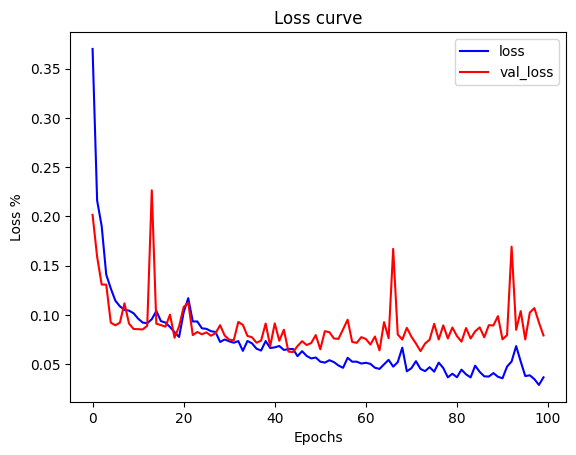

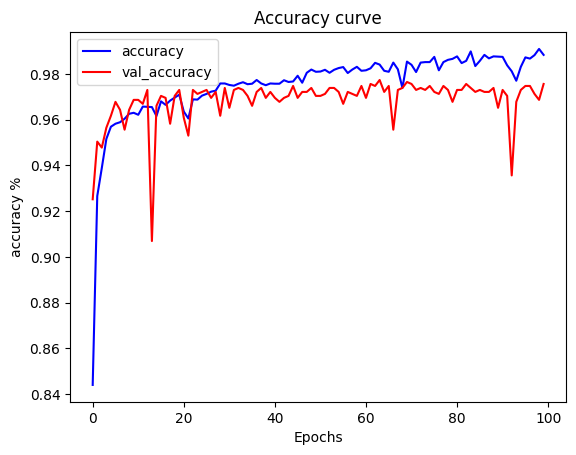





---- GRU unit = 64-------
Epoch 1/100
288/288 [==============================] - 6s 11ms/step - loss: 0.3308 - accuracy: 0.8603 - val_loss: 0.1703 - val_accuracy: 0.9470
Epoch 2/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1952 - accuracy: 0.9302 - val_loss: 0.1125 - val_accuracy: 0.9600
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1364 - accuracy: 0.9527 - val_loss: 0.0952 - val_accuracy: 0.9617
Epoch 4/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1114 - accuracy: 0.9609 - val_loss: 0.0827 - val_accuracy: 0.9670
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1039 - accuracy: 0.9622 - val_loss: 0.0990 - val_accuracy: 0.9661
Epoch 6/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1120 - accuracy: 0.9602 - val_loss: 0.1009 - val_accuracy: 0.9643
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0938 - accuracy: 0.9642 - val_l

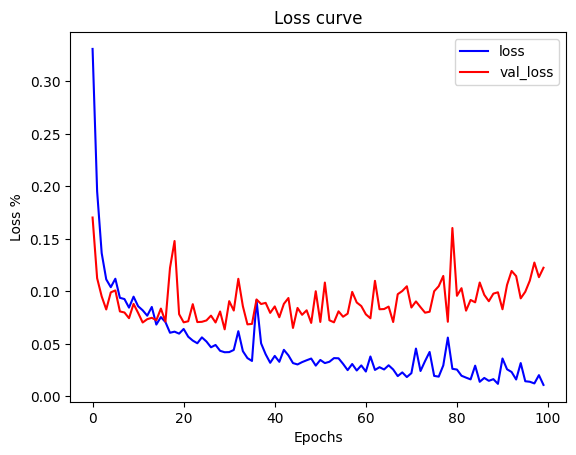

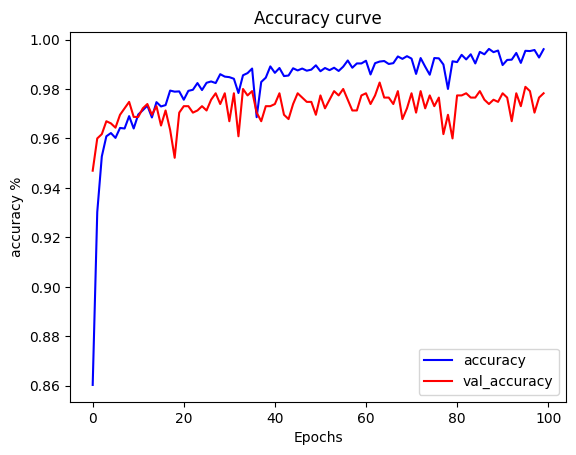





---- GRU unit = 128-------
Epoch 1/100
288/288 [==============================] - 7s 13ms/step - loss: 0.2847 - accuracy: 0.8908 - val_loss: 0.1264 - val_accuracy: 0.9591
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1613 - accuracy: 0.9472 - val_loss: 0.0997 - val_accuracy: 0.9600
Epoch 3/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1219 - accuracy: 0.9559 - val_loss: 0.0939 - val_accuracy: 0.9635
Epoch 4/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1078 - accuracy: 0.9599 - val_loss: 0.1108 - val_accuracy: 0.9548
Epoch 5/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1025 - accuracy: 0.9633 - val_loss: 0.1053 - val_accuracy: 0.9696
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0937 - accuracy: 0.9684 - val_loss: 0.0781 - val_accuracy: 0.9643
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0868 - accuracy: 0.9672 - v

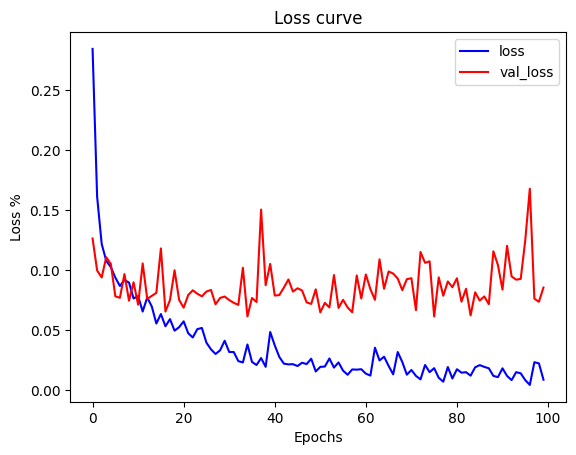

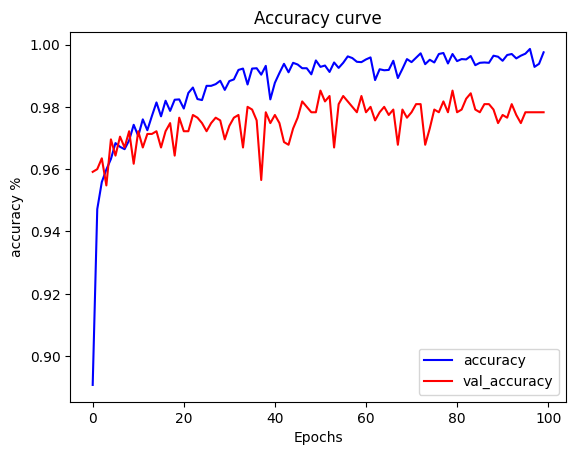





---- GRU unit = 256-------
Epoch 1/100
288/288 [==============================] - 7s 15ms/step - loss: 0.2156 - accuracy: 0.9198 - val_loss: 0.1337 - val_accuracy: 0.9365
Epoch 2/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1348 - accuracy: 0.9543 - val_loss: 0.1163 - val_accuracy: 0.9652
Epoch 3/100
288/288 [==============================] - 3s 12ms/step - loss: 0.1073 - accuracy: 0.9611 - val_loss: 0.0953 - val_accuracy: 0.9635
Epoch 4/100
288/288 [==============================] - 4s 13ms/step - loss: 0.0927 - accuracy: 0.9676 - val_loss: 0.0841 - val_accuracy: 0.9687
Epoch 5/100
288/288 [==============================] - 4s 12ms/step - loss: 0.0915 - accuracy: 0.9683 - val_loss: 0.0764 - val_accuracy: 0.9696
Epoch 6/100
288/288 [==============================] - 3s 12ms/step - loss: 0.0830 - accuracy: 0.9662 - val_loss: 0.1014 - val_accuracy: 0.9704
Epoch 7/100
288/288 [==============================] - 3s 12ms/step - loss: 0.0801 - accuracy: 0.9686 - v

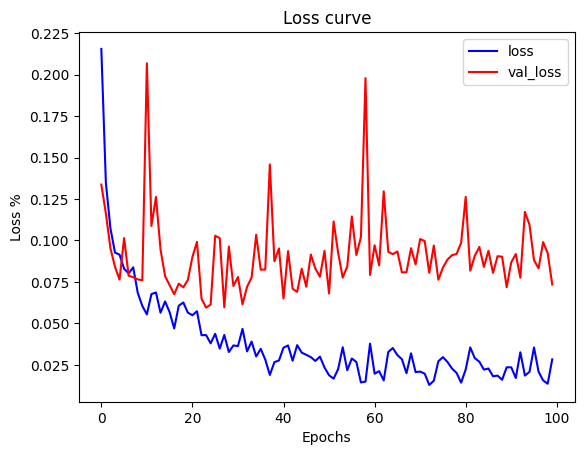

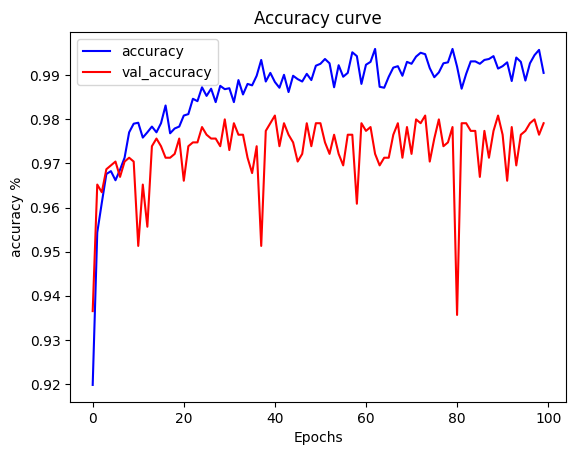





---- GRU unit = 512-------
Epoch 1/100
288/288 [==============================] - 10s 24ms/step - loss: 0.2010 - accuracy: 0.9238 - val_loss: 0.1047 - val_accuracy: 0.9609
Epoch 2/100
288/288 [==============================] - 6s 22ms/step - loss: 0.1254 - accuracy: 0.9583 - val_loss: 0.1197 - val_accuracy: 0.9548
Epoch 3/100
288/288 [==============================] - 6s 22ms/step - loss: 0.1067 - accuracy: 0.9625 - val_loss: 0.0992 - val_accuracy: 0.9678
Epoch 4/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0972 - accuracy: 0.9671 - val_loss: 0.0986 - val_accuracy: 0.9626
Epoch 5/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0917 - accuracy: 0.9653 - val_loss: 0.0913 - val_accuracy: 0.9722
Epoch 6/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0884 - accuracy: 0.9674 - val_loss: 0.0802 - val_accuracy: 0.9730
Epoch 7/100
288/288 [==============================] - 6s 22ms/step - loss: 0.1051 - accuracy: 0.9625 - 

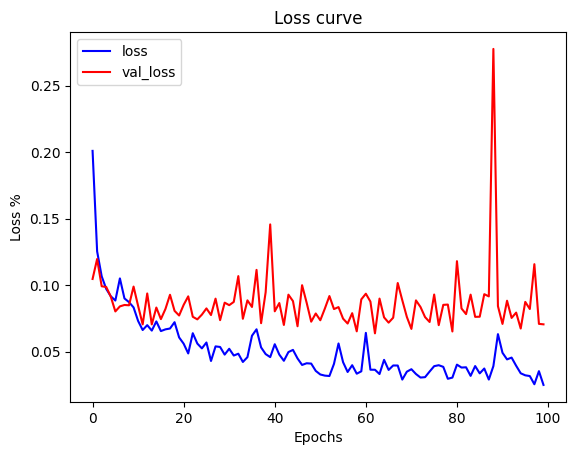

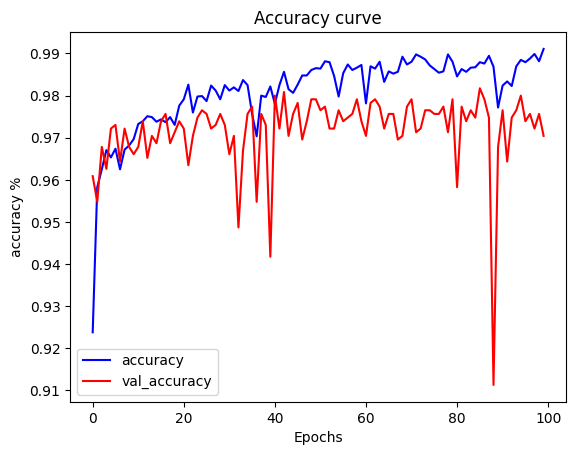





---- GRU unit = 1024-------
Epoch 1/100
288/288 [==============================] - 20s 55ms/step - loss: 0.1939 - accuracy: 0.9241 - val_loss: 0.1376 - val_accuracy: 0.9617
Epoch 2/100
288/288 [==============================] - 16s 54ms/step - loss: 0.1257 - accuracy: 0.9533 - val_loss: 0.1125 - val_accuracy: 0.9574
Epoch 3/100
288/288 [==============================] - 15s 52ms/step - loss: 0.1216 - accuracy: 0.9560 - val_loss: 0.1277 - val_accuracy: 0.9487
Epoch 4/100
288/288 [==============================] - 15s 51ms/step - loss: 0.1111 - accuracy: 0.9600 - val_loss: 0.2077 - val_accuracy: 0.9365
Epoch 5/100
288/288 [==============================] - 15s 52ms/step - loss: 0.1071 - accuracy: 0.9613 - val_loss: 0.0951 - val_accuracy: 0.9661
Epoch 6/100
288/288 [==============================] - 15s 52ms/step - loss: 0.1030 - accuracy: 0.9629 - val_loss: 0.1170 - val_accuracy: 0.9443
Epoch 7/100
288/288 [==============================] - 16s 54ms/step - loss: 0.0970 - accuracy: 0.

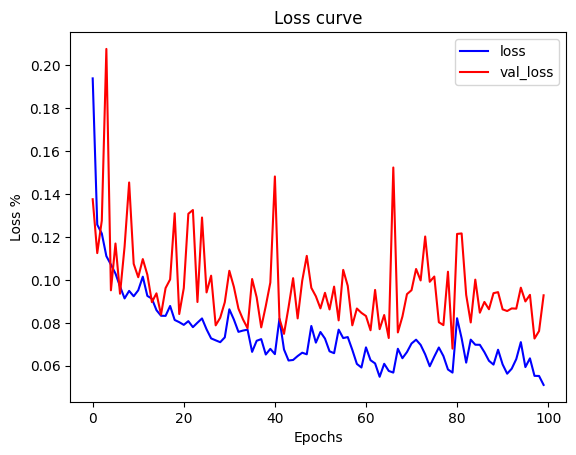

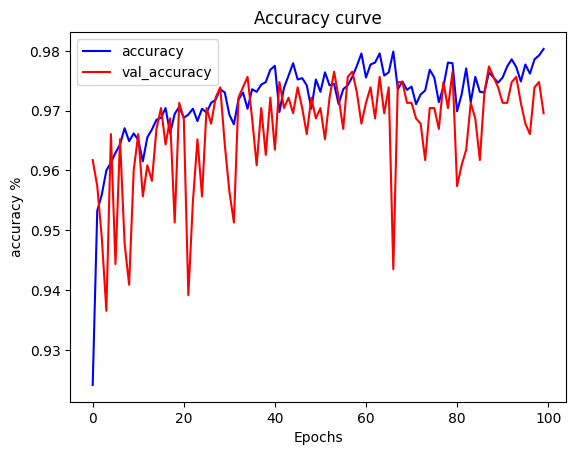

In [ ]:
gru_all_units = [8, 16, 32, 64, 128, 256, 512, 1024]

all_gruunits_history = []
all_gruunits_models = []

for gru_units in gru_all_units:
    model = eegClassifier(input_shape, gru_units)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print('\n\n\n')
    print(f'---- GRU unit = {gru_units}-------')
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
    all_gruunits_models.append(model)
    print('\n\n')
    print(model.summary())
    print('\n')
    plot_loss(history)
    plot_accuracy(history) 

    all_gruunits_history.append(history)

In [ ]:
class eegClassifier(keras.Model):
    def __init__(self, input_shape, gru_layers_num):
        super(eegClassifier, self).__init__()

        self.gru_layers = []
        for i in range(gru_layers_num):
            gru_layer = GRU(units=128 * 2**i, return_sequences=True if i < gru_layers_num-1 else False)
            setattr(self, f'gru_{i}', gru_layer)
            self.gru_layers.append(gru_layer)

        self.bn = BatchNormalization()
        self.dropout = Dropout(0.3)

        self.dense_1 = Dense(units=32, activation='relu')
        self.dense_2 = Dense(units=64, activation='relu')
        self.output_layer = Dense(units=2, activation='softmax')


    def call(self, inputs):
        x = inputs
        for gru_layer in self.gru_layers:
            x = self.dropout(gru_layer(x))
        x = self.bn(self.dropout(self.dense_1(x)))
        x = self.dropout(self.dense_2(x))
        x = self.output_layer(x)

        return x


## Let's experiment with GRU layers

`gru_all_layers= [1, 2, 3, 4, 5, 6]`





---- lstm layer num = 1-------
Epoch 1/100
288/288 [==============================] - 12s 13ms/step - loss: 0.3137 - accuracy: 0.8767 - val_loss: 0.1728 - val_accuracy: 0.9409
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1777 - accuracy: 0.9432 - val_loss: 0.1146 - val_accuracy: 0.9522
Epoch 3/100
288/288 [==============================] - 3s 11ms/step - loss: 0.1455 - accuracy: 0.9534 - val_loss: 0.1645 - val_accuracy: 0.9443
Epoch 4/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1285 - accuracy: 0.9592 - val_loss: 0.0929 - val_accuracy: 0.9678
Epoch 5/100
288/288 [==============================] - 3s 9ms/step - loss: 0.1238 - accuracy: 0.9576 - val_loss: 0.1052 - val_accuracy: 0.9643
Epoch 6/100
288/288 [==============================] - 3s 10ms/step - loss: 0.1077 - accuracy: 0.9628 - val_loss: 0.0996 - val_accuracy: 0.9643
Epoch 7/100
288/288 [==============================] - 3s 10ms/step - loss: 0.0956 - accuracy: 0.9686

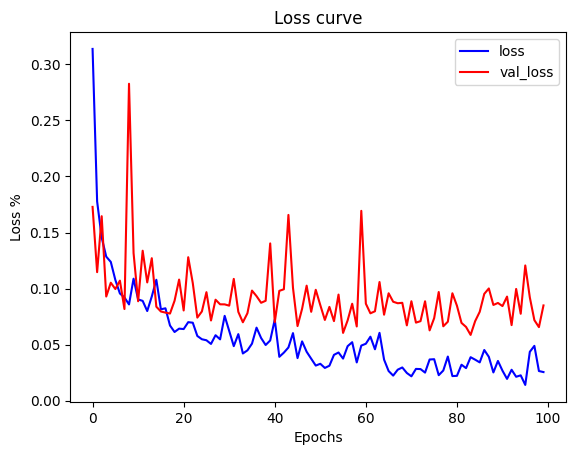

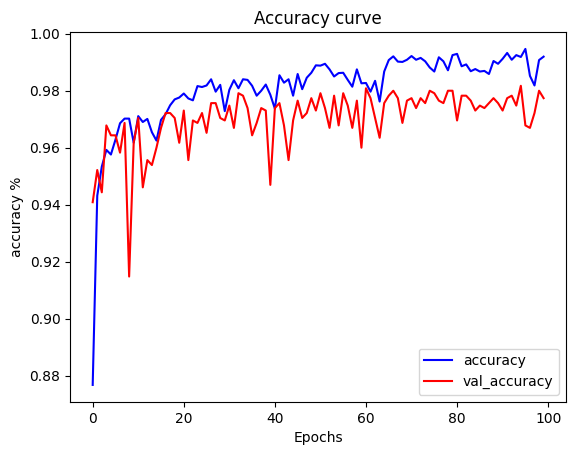





---- lstm layer num = 2-------
Epoch 1/100
288/288 [==============================] - 12s 26ms/step - loss: 0.2384 - accuracy: 0.9171 - val_loss: 0.5410 - val_accuracy: 0.8017
Epoch 2/100
288/288 [==============================] - 5s 19ms/step - loss: 0.1796 - accuracy: 0.9385 - val_loss: 0.1146 - val_accuracy: 0.9574
Epoch 3/100
288/288 [==============================] - 6s 20ms/step - loss: 0.1334 - accuracy: 0.9547 - val_loss: 0.1318 - val_accuracy: 0.9522
Epoch 4/100
288/288 [==============================] - 6s 19ms/step - loss: 0.1243 - accuracy: 0.9543 - val_loss: 0.1292 - val_accuracy: 0.9496
Epoch 5/100
288/288 [==============================] - 6s 19ms/step - loss: 0.1090 - accuracy: 0.9620 - val_loss: 0.1746 - val_accuracy: 0.9435
Epoch 6/100
288/288 [==============================] - 6s 20ms/step - loss: 0.1094 - accuracy: 0.9571 - val_loss: 0.1522 - val_accuracy: 0.9574
Epoch 7/100
288/288 [==============================] - 5s 18ms/step - loss: 0.0980 - accuracy: 0.964

In [ ]:
gru_all_layers= [1, 2, 3, 4, 5, 6]

all_grulayers_history = []
all_grulayers_models = []

for gru_layers_num in gru_all_layers:
    model = eegClassifier(input_shape, gru_layers_num)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print('\n\n\n')
    print(f'---- gru layer num = {gru_layers_num}-------')
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
    all_grulayers_models.append(model)
    print('\n\n')
    print(model.summary())
    print('\n')
    plot_loss(history)
    plot_accuracy(history) 

    all_grulayers_history.append(history)